# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Segmentation and Clustering Neighborhoods in London

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

Wondering what shapes the prices of real estate in the city?
Why, even in nearby districts, real estate property prices differ so much from each other.
I would like to examine whether there is a relationship between value of real estate and crime level in the district.
For developers, sellers and buyers of real estate, as well as for companies that want to build new offices in interesting districts, the following questions may be answered:
Which districts have the highest real estate prices?
Does crime affect real estate prices?
Using the Foursquare data, what are the most common venues in the different locations within the most suitable district of London?
Where is the best place within the most suitable district to run own business e.g. restaurant or invest in new building?


## Data <a name="data"></a>

To understand and explore the problem I will use the below data:<br>
**1.	London DataStore:** https://data.london.gov.uk/dataset/recorded_crime_summary <br>
The file is in csv format. The data includes name of crime, the BoroughName and the number of crimes. The data will be imported to Data Frame.
Example of data:
Arson and Criminal Damage,Arson,Barking and Dagenham,13<br>
**2.	Gov.uk HM Land Registry Price Paid Data:** https://www.gov.uk/guidance/about-the-price-paid-data<br>
The file is in csv format. The data includes among others Price, Property Type, Street, Locality, District.
Example of data:
"{79A74E21-C934-1289-E053-6B04A8C01627}","177000","2018-09-21 00:00","LE4 6EE","S","N","F","201","","BELPER STREET","","LEICESTER","LEICESTER","LEICESTER","A","A"<br>
**3.	Foursquare for developers access to venue data:** https://foursquare.com/<br>
Foursquare data provides information about venues in the Borough. Data will be obtained using **Foursquare API**. This data will be joined with data from above data.<br>
**4.	WikiPedia:** https://en.wikipedia.org/wiki/List_of_London_boroughs<br>
To obtain the list of London Boroughs with geodata.  
Example of data:
Barnet, Barnet London Borough Council, Conservative
North London Business Park, Oakleigh Road South, 33.49, 369,088, 51.6252°N 0.1517°W, 31.<br>
Data will be obtained using BeautifulSoup library.<br>
**5.	WikiPedia https://en.wikipedia.org/wiki/List_of_districts_in_the_London_Borough_of_Bromley**<br>
To obtain the list of Bromley Boroughs,  one of the London District for detailed analysis.

The above data should allow to confirm or deny the above thesis and answer the questions. These data should allow the visualization of data and the division of districts according to prices, and determine the most expensive districts of the city of London.
The crime data allow us locate and visualise the London districts with low, medium and high level of crimes. 
The data with real estate prices in different places of London allow us to find the districts with low, medium and high prices.
The data obtained from WikiPedia  should  allow to analyse in detail one of the district - Bromley.


### Load Libraries

In [1]:
import pandas as pd
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
from bs4 import BeautifulSoup
import requests 
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors


### Loading the data.

After loading the necessary libraries the files in csv format will be downloaded from web pages to local disk.<br> 
Data in csv format downloaded from the London DATASTORE website contain information provided by Metropolitan police.

In [2]:
df_crimes = pd.read_csv('C:\Data\MPS Borough Level Crime (most recent 24 months).csv')

In [3]:
df_crimes.head()

,MajorText,MinorText,LookUp_BoroughName,201704,201705,201706,201707,201708,201709,201710,...,201806,201807,201808,201809,201810,201811,201812,201901,201902,201903
0,Arson and Criminal Damage,Arson,Barking and Dagenham,13,6,14,2,5,8,7,...,12,6,5,3,8,6,1,5,2,5
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,139,147,150,143,169,134,132,...,123,127,101,107,131,105,89,97,127,136
2,Burglary,Burglary - Business and Community,Barking and Dagenham,32,29,19,42,30,25,23,...,33,30,18,33,32,39,33,44,24,30
3,Burglary,Burglary - Residential,Barking and Dagenham,101,129,71,95,83,81,122,...,77,94,84,99,94,106,164,114,107,98
4,Drug Offences,Drug Trafficking,Barking and Dagenham,4,4,6,7,1,6,6,...,6,8,7,9,6,7,2,5,1,6


Dropping all columns with number of crimes except 201903

In [4]:
df_crimes = df_crimes.drop(df_crimes.columns[3:26], axis=1)
df_crimes.head()

,MajorText,MinorText,LookUp_BoroughName,201903
0,Arson and Criminal Damage,Arson,Barking and Dagenham,5
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,136
2,Burglary,Burglary - Business and Community,Barking and Dagenham,30
3,Burglary,Burglary - Residential,Barking and Dagenham,98
4,Drug Offences,Drug Trafficking,Barking and Dagenham,6


Changing BoroughName to upper case to join data with additional sets.

In [5]:
df_crimes['LookUp_BoroughName'] = df_crimes['LookUp_BoroughName'].str.upper() 

### What is the crime by neighbourhood?

What is the count crime by neighbourhood?

In [6]:
crimes_count = df_crimes.groupby(['LookUp_BoroughName']).size().to_frame(name='Count').reset_index()
crimes_count.head()

,LookUp_BoroughName,Count
0,BARKING AND DAGENHAM,44
1,BARNET,49
2,BEXLEY,47
3,BRENT,50
4,BROMLEY,45


In [63]:
crimes_count.describe()

,Count
count,33.000000
mean,48.242424
std,2.817693
min,38.000000
25%,47.000000
50%,49.000000
75%,50.000000
max,52.000000


What is the sum of crimes by neighbourhood ?

In [187]:
crimes_sum = df_crimes.groupby('LookUp_BoroughName')['201903'].agg(['sum'])
crimes_sum.head()

,sum
LookUp_BoroughName,
BARKING AND DAGENHAM,1708
BARNET,2815
BEXLEY,1426
BRENT,2643
BROMLEY,2091


For further analysis we need geolocation data of London boroughs.<br>
The data was available on wikiPedia page, so I decided to obtain it using BeautifulSoup libraries.

In [8]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'

url_content = requests.get(wiki_url).text
soup = BeautifulSoup(url_content, 'lxml')

In [9]:
bl = soup.find_all('table', {'class':'wikitable sortable'})

In [10]:
tab = bl[0].find_all('tr')

In table now I have all needed data, I will get the needed data using below code

In [33]:
Borough   = []
longitude = []
latitude  = []


for r in tab:
    cols = r.find_all('td')
    if len(cols) > 8:
        bn = cols[0].text
        bn = bn.split('[')[0].strip().upper()
        p = cols[8].text
        s = p.split('/')
        s = s[2].split('\ufeff')
        s = s[0].split(';')
        Borough.append(bn)
        latitude.append(float(s[0]))
        longitude.append(float(s[1]))
        
        
df_geoLondon = pd.DataFrame()
nlist = {'Borough':Borough, 'Latitude':latitude, 'Longitude':longitude}
df_geoLondon = pd.DataFrame(nlist)
df_geoLondon.head()   

,Borough,Latitude,Longitude
0,BARKING AND DAGENHAM,51.5607,0.1557
1,BARNET,51.6252,-0.1517
2,BEXLEY,51.4549,0.1505
3,BRENT,51.5588,-0.2817
4,BROMLEY,51.4039,0.0198


Let's add to our geolocation data frame with boroughts column with count of crimes and create a new data frame.

In [36]:
df_crime_count_geo = df_geoLondon.join(crimes_count.set_index('LookUp_BoroughName'), on='Borough')

In [37]:
df_crime_count_geo.head()

,Borough,Latitude,Longitude,Count
0,BARKING AND DAGENHAM,51.5607,0.1557,44
1,BARNET,51.6252,-0.1517,49
2,BEXLEY,51.4549,0.1505,47
3,BRENT,51.5588,-0.2817,50
4,BROMLEY,51.4039,0.0198,45


Let's visualize the data of crimes on the map of London.

In [38]:
address = 'London, England'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of england, London is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of england, London is 51.5073219, -0.1276474.


In [148]:
world_geo = 'world_countries.json' # geojson file
London_map = folium.Map(location=[latitude, longitude], width=1000, height=750,zoom_start=10)

To visualising the data I defined three thresholds of crime levels.

In [154]:
def crime_level(cnt):
    if cnt < 47:
        return 'green'
    elif 47 <= cnt < 51:
        return 'orange'
    else:
        return 'red'


for lat, lng, borough, cnt in zip(df_crime_count_geo['Latitude'], df_crime_count_geo['Longitude'], df_crime_count_geo['Borough'], df_crime_count_geo['Count']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=crime_level(cnt),
        fill_opacity=0.8,
        parse_html=False).add_to(London_map)

In [155]:
London_map

### Examine crime types

In [75]:
crime_types = df_crimes.groupby(['MajorText']).size().to_frame(name='Count').reset_index()
crime_types

,MajorText,Count
0,Arson and Criminal Damage,66
1,Burglary,65
2,Drug Offences,66
3,Miscellaneous Crimes Against Society,622
4,Possession of Weapons,153
5,Public Order Offences,128
6,Robbery,65
7,Sexual Offences,66
8,Theft,132
9,Vehicle Offences,132


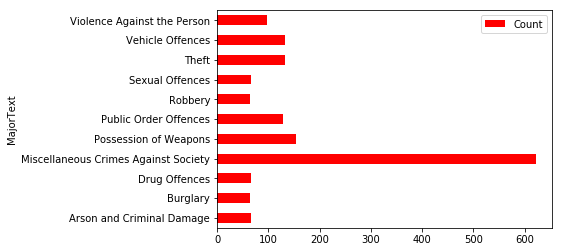

In [76]:
crime_types.plot(x='MajorText', y='Count', kind='barh', color='red')


In [77]:
crimeDataPiv = df_crimes.pivot_table(index='LookUp_BoroughName', columns='MajorText', aggfunc=pd.Series.count, fill_value=0)
crimeDataPiv.head()

201903                         \
MajorText            Arson and Criminal Damage Burglary Drug Offences   
LookUp_BoroughName                                                      
BARKING AND DAGENHAM                         2        2             2   
BARNET                                       2        2             2   
BEXLEY                                       2        2             2   
BRENT                                        2        2             2   
BROMLEY                                      2        2             2   

                                                           \
MajorText            Miscellaneous Crimes Against Society   
LookUp_BoroughName                                          
BARKING AND DAGENHAM                                   14   
BARNET                                                 20   
BEXLEY                                                 17   
BRENT                                                  20   
BROMLEY                                                16   

                                                                          \
MajorText            Possession of Weapons Public Order Offences Robbery   
LookUp_BoroughName                                                         
BARKING AND DAGENHAM                     5                     4       2   
BARNET                                   5                     3       2   
BEXLEY                                   5                     4       2   
BRENT                                    5                     4       2   
BROMLEY                                  4                     4       2   

                                                             ... MinorText  \
MajorText            Sexual Offences Theft Vehicle Offences  ...  Burglary   
LookUp_BoroughName                                           ...             
BARKING AND DAGENHAM               2     4                4  ...         2   
BARNET                             2     4                4  ...         2   
BEXLEY                             2     4                4  ...         2   
BRENT                              2     4                4  ...         2   
BROMLEY                            2     4                4  ...         2   

                                                                         \
MajorText            Drug Offences Miscellaneous Crimes Against Society   
LookUp_BoroughName                                                        
BARKING AND DAGENHAM             2                                   14   
BARNET                           2                                   20   
BEXLEY                           2                                   17   
BRENT                            2                                   20   
BROMLEY                          2                                   16   

                                                                          \
MajorText            Possession of Weapons Public Order Offences Robbery   
LookUp_BoroughName                                                         
BARKING AND DAGENHAM                     5                     4       2   
BARNET                                   5                     3       2   
BEXLEY                                   5                     4       2   
BRENT                                    5                     4       2   
BROMLEY                                  4                     4       2   

                                                             \
MajorText            Sexual Offences Theft Vehicle Offences   
LookUp_BoroughName                                            
BARKING AND DAGENHAM               2     4                4   
BARNET                             2     4                4   
BEXLEY                             2     4                4   
BRENT                              2     4                4   
BROMLEY                            2     4                4   

                 

### Let's examine the most common crime - Possession of Weapons.

In [78]:
df_pow = df_crimes.loc[df_crimes['MajorText'] == 'Possession of Weapons']
df_pow.head()


,MajorText,MinorText,LookUp_BoroughName,201903
20,Possession of Weapons,Other Firearm Offences,BARKING AND DAGENHAM,0
21,Possession of Weapons,Possession of Firearm with Intent,BARKING AND DAGENHAM,2
22,Possession of Weapons,Possession of Firearms Offences,BARKING AND DAGENHAM,4
23,Possession of Weapons,Possession of Other Weapon,BARKING AND DAGENHAM,8
24,Possession of Weapons,Possession of Article with Blade or Point,BARKING AND DAGENHAM,9


Drop rows with value 0

In [79]:
df_pow = df_pow[df_pow['201903'] != 0]
df_pow.head()

,MajorText,MinorText,LookUp_BoroughName,201903
21,Possession of Weapons,Possession of Firearm with Intent,BARKING AND DAGENHAM,2
22,Possession of Weapons,Possession of Firearms Offences,BARKING AND DAGENHAM,4
23,Possession of Weapons,Possession of Other Weapon,BARKING AND DAGENHAM,8
24,Possession of Weapons,Possession of Article with Blade or Point,BARKING AND DAGENHAM,9
71,Possession of Weapons,Possession of Firearm with Intent,BARNET,1


Let's group data by borough

In [80]:
pow_data = df_pow.groupby('LookUp_BoroughName')['201903'].agg(['sum'])
pow_data = pow_data.reset_index()
pow_data.head()

,LookUp_BoroughName,sum
0,BARKING AND DAGENHAM,23
1,BARNET,12
2,BEXLEY,12
3,BRENT,18
4,BROMLEY,15


In [81]:
pow_data.describe()

,sum
count,33.000000
mean,21.969697
std,12.200115
min,5.000000
25%,12.000000
50%,22.000000
75%,25.000000
max,48.000000


### Let's visualise the distribution of most common crime - Possession of Weapons.

Create new data frame with geolocation and sum of crimes in each borough.

In [51]:
df_crime_sum_geo = df_geoLondon.join(pow_data.set_index('LookUp_BoroughName'), on='Borough')
df_crime_sum_geo.head()

,Borough,Latitude,Longitude,sum
0,BARKING AND DAGENHAM,51.5607,0.1557,23
1,BARNET,51.6252,-0.1517,12
2,BEXLEY,51.4549,0.1505,12
3,BRENT,51.5588,-0.2817,18
4,BROMLEY,51.4039,0.0198,15


In [146]:
def crime_level(cnt):
    if cnt < 16:
        return 'green'
    elif 16 <= cnt < 24:
        return 'orange'
    else:
        return 'red'


for lat, lng, borough, cnt in zip(df_crime_sum_geo['Latitude'], df_crime_sum_geo['Longitude'], df_crime_sum_geo['Borough'], df_crime_sum_geo['sum']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color=crime_level(cnt),
        fill_opacity=0.8,
        parse_html=False).add_to(London_map)

In [147]:
London_map

If we look at the crime distribution map we can see that Bromley has low level of crimes compare to the nearby districts of London. In the further analysis I focus on this place to find the best place to investment.

Let's get data with real estate prices. The file in csv format in first step was downloaded from web page into local disk.

In [88]:
df_assets = pd.read_csv('C:\Data\pp-monthly-update-new-version.csv', header=None)
df_assets.columns = ['Tui', 'Price', 'DateOfTransfer', 'Postcode', 'PropertyType', 'New', 'Duration', 'PAON', \
                  'SAON', 'Street', 'Locality', 'TownCity', 'District', 'County', 'PPDCT', 'RecordStatus']

In [89]:
df_assets.head()

,Tui,Price,DateOfTransfer,Postcode,PropertyType,New,Duration,PAON,SAON,Street,Locality,TownCity,District,County,PPDCT,RecordStatus
0,{85866A65-5D4D-143F-E053-6B04A8C06A15},83000,2002-02-01 00:00,CF72 9JA,D,N,F,1A,NaN,GELLI ROAD,LLANHARRY,PONTYCLUN,RHONDDA CYNON TAFF,RHONDDA CYNON TAFF,A,A
1,{85866A64-68E1-143F-E053-6B04A8C06A15},80000,2002-04-11 00:00,SL1 5AE,F,N,L,2,NaN,OAKFIELD AVENUE,NaN,SLOUGH,SLOUGH,SLOUGH,A,A
2,{85866A64-6936-143F-E053-6B04A8C06A15},270000,2002-08-09 00:00,RG31 5DB,D,N,L,YORK LODGE,44,PEGASUS COURT,TILEHURST,READING,READING,READING,A,A
3,{85866A64-7718-143F-E053-6B04A8C06A15},250000,2002-03-15 00:00,TS14 8PR,T,Y,F,"STABLE HOUSE, 3",NaN,PEASE COURT,NaN,GUISBOROUGH,REDCAR AND CLEVELAND,REDCAR AND CLEVELAND,A,A
4,{85866A64-9067-143F-E053-6B04A8C06A15},72500,2002-05-31 00:00,EX10 9ES,F,N,L,CHEGWORTH,FLAT 1,ARCOT ROAD,NaN,SIDMOUTH,EAST DEVON,DEVON,A,A


Let's look on the statistic of data.

In [90]:
df_assets.describe()

,Price
count,9.594300e+04
mean,3.580039e+05
std,1.765491e+06
min,1.000000e+00
25%,1.420000e+05
50%,2.249950e+05
75%,3.499950e+05
max,2.617109e+08


Make a list of all boroughs of London, which we analysed so far.

In [91]:
l = pow_data['LookUp_BoroughName'].tolist()
l

['BARKING AND DAGENHAM',
 'BARNET',
 'BEXLEY',
 'BRENT',
 'BROMLEY',
 'CAMDEN',
 'CROYDON',
 'EALING',
 'ENFIELD',
 'GREENWICH',
 'HACKNEY',
 'HAMMERSMITH AND FULHAM',
 'HARINGEY',
 'HARROW',
 'HAVERING',
 'HILLINGDON',
 'HOUNSLOW',
 'ISLINGTON',
 'KENSINGTON AND CHELSEA',
 'KINGSTON UPON THAMES',
 'LAMBETH',
 'LEWISHAM',
 'LONDON HEATHROW AND LONDON CITY AIRPORTS',
 'MERTON',
 'NEWHAM',
 'REDBRIDGE',
 'RICHMOND UPON THAMES',
 'SOUTHWARK',
 'SUTTON',
 'TOWER HAMLETS',
 'WALTHAM FOREST',
 'WANDSWORTH',
 'WESTMINSTER']

Select from dataframe of all places with real estate price, only those, which we analysis. 

In [92]:
df_assets = df_assets[df_assets['District'].isin(l)]
df_assets.head()

,Tui,Price,DateOfTransfer,Postcode,PropertyType,New,Duration,PAON,SAON,Street,Locality,TownCity,District,County,PPDCT,RecordStatus
17,{85866A64-EC32-143F-E053-6B04A8C06A15},115000,2002-10-29 00:00,SE4 2SS,T,N,F,83,NaN,FOXBERRY ROAD,NaN,LONDON,LEWISHAM,GREATER LONDON,A,A
27,{3412C1B2-811B-41D0-A69C-539C980D90FD},110000,2002-08-16 00:00,E9 5RH,T,N,L,3B,NaN,MABLEY STREET,NaN,LONDON,HACKNEY,GREATER LONDON,A,C
42,{D1A0C383-5B35-4D8D-9CE1-F183C804FC49},117000,2002-12-18 00:00,E11 1PP,F,N,L,8A,NaN,HOLLYBUSH HILL,NaN,LONDON,REDBRIDGE,GREATER LONDON,A,C
53,{57287FDF-7706-460A-BEFD-8831A837D118},223000,2002-05-28 00:00,TW1 4SJ,F,N,L,97,GROUND FLOOR FLAT,STRAWBERRY VALE,NaN,TWICKENHAM,RICHMOND UPON THAMES,GREATER LONDON,A,C
55,{175BEBD5-1FD8-494F-834C-B25D89A9A82F},107000,2002-02-12 00:00,SE14 5NS,F,N,L,39C,BASEMENT FLAT,OMMANEY ROAD,NEW CROSS,LONDON,LEWISHAM,GREATER LONDON,A,C


In our project I decided to analyse in detail one of the district of London Bromley.
For further analysis, I need data about Bromley boroughts with geolocation. I found the WikiPedia website with a list of boroughts. Having the list of boroughts, I will use the geolocation API to get the geolocation of each boroughts.

In [93]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_districts_in_the_London_Borough_of_Bromley'

url_content = requests.get(wiki_url).text
soup = BeautifulSoup(url_content, 'lxml')   
tab = soup.find('div', {'class' : 'mw-parser-output'})
tab = tab.findAll('li')

In the WikiPedia web page is only the list of boroughs of Bromley without geolocation data. To obtain geolocation of every Bromley borough I run geolocation API to obtain Longitude and Latitude.

In [94]:
Borough   = []
Longitude = []
Latitude  = []


for r in tab:
    c = r.find_all('a')
    if len(c) > 0 :
        c = c[0].text
        if len(c) < 2:
            break
        else:    
            geolocator = Nominatim(user_agent="ny_explorer")
            location = geolocator.geocode(c + ', Bromley')
            latitude = location.latitude
            longitude = location.longitude
            Borough.append(c.upper())
            Latitude.append(latitude)
            Longitude.append(longitude)
        
df_geoBromley = pd.DataFrame()
nlist = {'Borough':Borough, 'Latitude':Latitude, 'Longitude':Longitude}
df_geoBromley = pd.DataFrame(nlist)
df_geoBromley.head() 

,Borough,Latitude,Longitude
0,ANERLEY,51.412848,-0.065301
1,APERFIELD,51.316629,0.032717
2,BECKENHAM,51.407094,-0.030318
3,BICKLEY,51.401740,0.043712
4,BIGGIN HILL,51.320037,0.009479


Looking good. So now we have all neighbors with geolocation and crime level and information about price of real estate.
This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations for a new investments.

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of London that have low level of crime and high value of real estates. We also in detail will analyse one of the London district Bromley. The reason is, that Bromley has low level of crimes compare to the neighbours and probably high level of real estate value. We will check it in thurther analysis.

In first step we have collected the required data: Crimes and real estate values of London borougs. We obtained also geolocation data. We also analised and visualised the data about crimes in each district of London. We also discovered that Bromley is the district of London with low crime level.

Second step in our analysis will be discover if the level of crime have influence of the real estate values. For this we use K-means clustering metod to divide the London districts according the price and crime level. 

In third and final step we will focus on most promising areas of Bromley and within those create clusters of locations that meet some basic requirements established in discussion with stakeholders. We will try to find area that is oustanding from other, where the stakeholders can invest.

## Analysis <a name="analysis"></a>

Let's check if the higher rate of crime have influence on real estate prices?
To do this we will add to our dataframe additional column with the crime sum for each district of London.

In [96]:
pow_data.head()

,LookUp_BoroughName,sum
0,BARKING AND DAGENHAM,23
1,BARNET,12
2,BEXLEY,12
3,BRENT,18
4,BROMLEY,15


In [100]:
df_ass_crime = df_assets.join(pow_data.set_index('LookUp_BoroughName'), on='District')
df_ass_crime = df_ass_crime.sort_values(by=['sum'])
df_ass_crime

,Tui,Price,DateOfTransfer,Postcode,PropertyType,New,Duration,PAON,SAON,Street,Locality,TownCity,District,County,PPDCT,RecordStatus,sum
28137,{85866A65-AC94-143F-E053-6B04A8C06A15},400000,2018-09-21 00:00,TW2 5NJ,O,N,L,"RETAIL UNIT 1, 224 - 230",NaN,HAMPTON ROAD,NaN,TWICKENHAM,RICHMOND UPON THAMES,GREATER LONDON,B,A,5
76091,{85866A65-026E-143F-E053-6B04A8C06A15},455000,2019-02-01 00:00,TW2 7PT,S,N,F,31,NaN,ROSECROFT GARDENS,NaN,TWICKENHAM,RICHMOND UPON THAMES,GREATER LONDON,A,A,5
76100,{85866A65-0277-143F-E053-6B04A8C06A15},1300000,2019-02-19 00:00,TW11 9JR,D,N,F,58,NaN,ST WINIFREDS ROAD,NaN,TEDDINGTON,RICHMOND UPON THAMES,GREATER LONDON,A,A,5
48326,{85866A65-4E23-143F-E053-6B04A8C06A15},950000,2019-02-12 00:00,SW13 0HF,T,N,F,4,NaN,LIMES AVENUE,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A,5
76102,{85866A65-0279-143F-E053-6B04A8C06A15},860000,2019-03-08 00:00,TW11 8PA,D,N,F,10,NaN,CHURCH LANE,NaN,TEDDINGTON,RICHMOND UPON THAMES,GREATER LONDON,A,A,5
76104,{85866A65-027B-143F-E053-6B04A8C06A15},725000,2019-03-07 00:00,KT1 4HR,D,N,F,12,NaN,MONMOUTH AVENUE,NaN,KINGSTON UPON THAMES,RICHMOND UPON THAMES,GREATER LONDON,A,A,5
76108,{85866A65-02C3-143F-E053-6B04A8C06A15},1150000,2019-03-11 00:00,TW1 1LA,S,N,F,83,NaN,WINCHESTER ROAD,NaN,TWICKENHAM,RICHMOND UPON THAMES,GREATER LONDON,A,A,5
48321,{85866A65-4E1D-143F-E053-6B04A8C06A15},1096500,2019-03-15 00:00,SW13 0PP,T,N,F,59,NaN,WHITE HART LANE,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A,5
1179,{711448E2-8208-441A-BBED-9D28802DB0CA},119950,1997-12-01 00:00,TW1 4SJ,F,N,L,97,GROUND FLOOR FLAT,STRAWBERRY VALE,NaN,TWICKENHAM,RICHMOND UPON THAMES,GREATER LONDON,A,C,5
48316,{85866A65-4E18-143F-E053-6B04A8C06A15},270000,2019-02-05 00:00,TW9 4QR,F,N,L,20,FLAT 7,LAMBERT AVENUE,NaN,RICHMOND,RICHMOND UPON THAMES,GREATER LONDON,A,A,5


In [101]:
df_assets.describe()

,Price
count,1.013100e+04
mean,7.803138e+05
std,3.024095e+06
min,1.500000e+02
25%,3.225000e+05
50%,4.400000e+05
75%,6.200000e+05
max,1.000000e+08


Let's find the average price, where crime incidents are the lowest and highest

In [102]:
df_ass_crime[df_ass_crime['sum'] == 5]['Price'].mean()

806636.8199233717

In [103]:
df_ass_crime[df_ass_crime['sum'] == 45]['Price'].mean()

686963.8363095238

Let's look where the prices are the highest and lowest

In [107]:
df_assets_geo = df_ass_crime.join(df_geoLondon.set_index('Borough'), on='District')
df_assets_geo = df_assets_geo.groupby(['District']).mean() 
df_assets_geo = df_assets_geo.reset_index()
df_assets_geo.head()

,District,Price,sum,Latitude,Longitude
0,BARKING AND DAGENHAM,344924.678112,23.0,51.5607,0.1557
1,BARNET,868022.700229,12.0,51.6252,-0.1517
2,BEXLEY,388745.295820,12.0,51.4549,0.1505
3,BRENT,699025.365462,18.0,51.5588,-0.2817
4,BROMLEY,762518.715859,15.0,51.4039,0.0198


In [157]:
world_geo = 'world_countries.json' # geojson file
London_map = folium.Map(location=[latitude, longitude], width=1000, height=750,zoom_start=10)

In [158]:
def assets_level(pri):
    if pri < 440000:
        return 'green'
    elif 440000 <= pri < 620000:
        return 'orange'
    else:
        return 'red'


for lat, lng, borough, pri in zip(df_assets_geo ['Latitude'], df_assets_geo ['Longitude'], df_assets_geo ['District'], df_assets_geo ['Price']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color=assets_level(pri),
        fill_opacity=0.8,
        parse_html=False).add_to(London_map)

In [159]:
London_map

### Cluster London Locations

In [141]:
# set number of clusters
kclusters = 3
London_price_clustering = df_assets_geo.drop(['District','Longitude','Latitude'], 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_price_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 0, 2, 0, 0, 1, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1, 1, 2, 0, 2,
       0, 0, 2, 0, 0, 2, 0, 2, 0])

In [142]:
# add clustering labels
df_assets_geo['Cluster Labels'] = kmeans.labels_
df_assets_geo.head()

,District,Price,sum,Latitude,Longitude,Cluster Labels
0,BARKING AND DAGENHAM,344924.678112,23.0,51.5607,0.1557,2
1,BARNET,868022.700229,12.0,51.6252,-0.1517,0
2,BEXLEY,388745.295820,12.0,51.4549,0.1505,2
3,BRENT,699025.365462,18.0,51.5588,-0.2817,0
4,BROMLEY,762518.715859,15.0,51.4039,0.0198,0


In [144]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
y = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(y)))
pallet = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_assets_geo['Latitude'], df_assets_geo['Longitude'], 
                                  df_assets_geo['District'], df_assets_geo['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5,popup=label,color=pallet[cluster-1],fill=True,fill_color=pallet[cluster-1],
    fill_opacity=0.6).add_to(map_clusters)
map_clusters

The highest prices are in KENSINGTON AND CHELSEA, CAMDEN and ISLINGTON. At the same time in these place the crime level is medium.
It's interesting obervation. The district BROMLEY have high prices of real estates compare to the nearby districts. 
If we look at the crime distribution map we can see that this place has low level of crimes.
Probably the high prices of real estates in this place are because of low level of crime.
Our assumption, that Bromley is probably the best place for investment was confirmed.

### Let's look at this specific locations - BROMLEY

In [160]:
address = 'BROMLEY, London'

geolocator = Nominatim(user_agent='foursquare_agent')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of BROMLEY are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of BROMLEY are 51.4028046, 0.0148142.


In [161]:
address = 'Bromley, England'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of england, London is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of england, London is 51.4028046, 0.0148142.


In [165]:
# create map of Bromley using latitude and longitude values


map_Bromley = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough in zip(df_geoBromley['Latitude'], df_geoBromley['Longitude'], df_geoBromley['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Bromley)  
    
map_Bromley

### Let's take a look at nearby venues of Bromley

Venues will be obtained using Foursquare API

In [166]:
# For security reason , data were removed
CLIENT_ID = ''
CLIENT_SECRET = ''

In [167]:
LIMIT = 30 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
VERSION = '20190101'


In [168]:
def getVenues(Boroughs, Latitudes, Longitudes, radius, LIMIT):

    vlist=[]
    for b, lat, lng in zip(Boroughs, Latitudes, Longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

            # get data
        results = requests.get(url).json()
        results = results['response']['groups'][0]['items']

        vlist.append([(b, lat, lng,
                ven['venue']['name'],
                ven['venue']['id'],
                ven['venue']['location']['lat'],
                ven['venue']['location']['lng'],
                ven['venue']['categories'][0]['name']) for ven in results])
            
    venues = pd.DataFrame([item for v in vlist for item in v])
    venues.columns = ['Location','Location Latitude','Location Longitude','Venue',
                            'Venue id', 'Venue Latitude', 'Venue Longitude','Venue Category']
    return(venues)

In [170]:
Bromley_venues = getVenues(Boroughs = df_geoBromley['Borough'], 
                            Latitudes = df_geoBromley['Latitude'],
                            Longitudes = df_geoBromley['Longitude'],
                            radius = radius, LIMIT = LIMIT)

In [171]:
Bromley_venues.head() 

,Location,Location Latitude,Location Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
0,ANERLEY,51.412848,-0.065301,The Douglas fir,56744ee738fa360643ac2d5a,51.414766,-0.070820,Pub
1,ANERLEY,51.412848,-0.065301,BP,508d079be4b055a758969168,51.413183,-0.068181,Gas Station
2,ANERLEY,51.412848,-0.065301,Wickes,59d7690f86f4cc7f7d1d97dc,51.412143,-0.065070,Hardware Store
3,ANERLEY,51.412848,-0.065301,Twang Guitars,4ef4550aa69d3d38d61fec2b,51.415961,-0.064454,Music Store
4,ANERLEY,51.412848,-0.065301,Betts Park,4cbadba60180721e6d5e9c61,51.408755,-0.067278,Park


In [172]:
print('There are {} unique venue categories.'.format(len(Bromley_venues['Venue Category'].unique())))

There are 91 unique venue categories.


In [173]:
print('There are {} unique venues.'.format(len(Bromley_venues['Venue id'].unique())))

There are 285 unique venues.


In [174]:
# one hot encoding
Bromley_onehot = pd.get_dummies(Bromley_venues[['Venue Category']], prefix="", prefix_sep="")

# add location column to dataframe
Bromley_onehot['Location'] = Bromley_venues['Location']

# move Location column to the first column
columns = [Bromley_onehot.columns[-1]] + list(Bromley_onehot.columns[:-1])
Bromley_onehot = Bromley_onehot[columns]
Bromley_onehot.head()

,Location,Airport Terminal,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Baby Store,Bakery,Bar,Bed & Breakfast,...,Sports Club,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Track Stadium,Train Station,Turkish Restaurant,Wine Shop
0,ANERLEY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ANERLEY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ANERLEY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ANERLEY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ANERLEY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
Bromley_onehot.shape

(325, 92)

### Grouping by location and average frequency of occurrence of each category

In [176]:
Bromleygrouped = Bromley_onehot.groupby('Location').mean().reset_index()
Bromleygrouped

,Location,Airport Terminal,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Baby Store,Bakery,Bar,Bed & Breakfast,...,Sports Club,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Track Stadium,Train Station,Turkish Restaurant,Wine Shop
0,ANERLEY,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,APERFIELD,0.333333,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
2,BECKENHAM,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.066667,0.000000,0.033333,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,BICKLEY,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.250000,0.000000,0.000000
4,BROMLEY,0.000000,0.000000,0.0000,0.033333,0.000000,0.0000,0.000000,0.033333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.033333,0.000000
5,BROMLEY COMMON,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,CHELSFIELD,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.250000,0.000000,0.000000
7,CHISLEHURST,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,CHISLEHURST COMMON,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,CONEY HALL,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [177]:
Bromleygrouped.shape

(41, 92)

### Rank of the top most common venues

In [178]:
def MostCommonVenues(row, TopVenues):
    categories = row.iloc[1:]
    categoriesSorted = categories.sort_values(ascending=False)
    return categoriesSorted.index.values[0:TopVenues]

In [179]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(10):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))
        
# create a new dataframe
location_venues_sorted = pd.DataFrame(columns=columns)
location_venues_sorted['Location'] = Bromleygrouped['Location']
for ind in np.arange(Bromleygrouped.shape[0]):
    location_venues_sorted.iloc[ind, 1:] = MostCommonVenues(Bromleygrouped.iloc[ind, :], 10)

location_venues_sorted.head()

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANERLEY,Grocery Store,Gas Station,Park,Hardware Store,Music Store,Pub,Wine Shop,Donut Shop,Cricket Ground,Dance Studio
1,APERFIELD,Airport Terminal,Pub,Music Venue,Café,Grocery Store,Athletics & Sports,Farm,Dance Studio,Deli / Bodega,Department Store
2,BECKENHAM,Coffee Shop,Italian Restaurant,Pub,Supermarket,Café,Park,Indian Restaurant,Mediterranean Restaurant,Grocery Store,Portuguese Restaurant
3,BICKLEY,Train Station,Cricket Ground,Home Service,Café,Wine Shop,English Restaurant,Dance Studio,Deli / Bodega,Department Store,Diner
4,BROMLEY,Coffee Shop,Clothing Store,Pub,Gym / Fitness Center,Pizza Place,Chocolate Shop,Sandwich Place,Department Store,Park,Donut Shop


### Cluster Brumley Locations

#### Run k-means to cluster Locations into 4 clusters

In [180]:
# set number of clusters
kclusters = 4
Bromley_grouped_clustering = Bromleygrouped.drop('Location', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Bromley_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 3, 0, 1, 0, 3, 0, 2, 3, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0])

In [182]:
Bromley_merged =  df_geoBromley.join(Bromleygrouped.set_index('Location'), on='Borough', how='inner')
Bromley_merged.head()

,Borough,Latitude,Longitude,Airport Terminal,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Baby Store,Bakery,...,Sports Club,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Track Stadium,Train Station,Turkish Restaurant,Wine Shop
0,ANERLEY,51.412848,-0.065301,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0
1,APERFIELD,51.316629,0.032717,0.333333,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0
2,BECKENHAM,51.407094,-0.030318,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.066667,0.0,0.033333,0.0,0.0,0.0,0.00,0.000000,0.0
3,BICKLEY,51.401740,0.043712,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.25,0.000000,0.0
5,BROMLEY,51.402805,0.014814,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.033333,0.0


In [183]:
# add clustering labels
Bromley_merged['Cluster Labels'] = kmeans.labels_
# merge fredericton_grouped with location df to add latitude/longitude for each location
Bromley_merged = Bromley_merged.join(location_venues_sorted.set_index('Location'), on='Borough')

In [185]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
y = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(y)))
pallet = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Bromley_merged['Latitude'], Bromley_merged['Longitude'], 
                                  Bromley_merged['Borough'], Bromley_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5,popup=label,color=pallet[cluster-1],fill=True,fill_color=pallet[cluster-1],
    fill_opacity=0.6).add_to(map_clusters)
map_clusters

The Elmstead is outstanding compare to the rest of boroughs. It is interesting why?
Probably because this place is adjacent to Sundridge Park and the place lie on Green Chain Walk.
In my opinion there is a good place for real estate investments.


This concludes our analysis. We have made analysis of London districts. We found districts of London with high real estate value and low or medium level of crime. We descovered based on clustering data, that Bromley is oustanding place compare to other districts of London. Next we made venues analysis in Bromley to find the best place ELMSTEAD for investment for example in new restaurant.

## Results and Discussion <a name="results"></a>

Our analysis showed that there are many places in London with low or medium crime levels. Average real estate prices in these places are higher than in places with high crime levels. Using the KMeans method, we found a district of London Bromley, which stood out from other places in London.
We have made a thorough analysis using the Foursquare API for the Bromley location. On its basis, the location was selected, which may be a good place for future investments.

Available data allowed us to analyze the number and type of crimes committed in a given area. However, the available data is not specific enough for a deeper analysis of the offenses committed. It would be interesting to check, for example, which ethnic groups are committed by particular types of crime. Are crimes committed by residents of a given district, or visitors. On the other hand, due to the protection of personal data, such analyzes can be performed only by authorized persons.
When viewing the visualization of the types of crimes committed, it can be seen that the largest number of committed crimes is classified as Miscellaneous Crimes Against Society. It is not known what exactly is hidden under this concept.
The data allowed to clearly confirm the correlation between the number of committed crimes and the price of real estate. However, it would be necessary to check whether these prices result only from low crime levels, or whether there are other factors determining the prices of real estate in a given place.
Interesting for investors may be that there are places, such as Bromley, where real estate prices are high and there is a low crime rate. I would suggest to be interested in this place for future investments. In particular, some areas of Bromley may be attractive for new investments due to the lack of, for example, hotels in some areas.


## Conclusion <a name="conclusion"></a>

Using publicly available data, we could do general analysis about crime in various districts of London. Based on data from real estate purchase and sale transactions, it was possible to check whether there is a correlation between average real estate prices and the level of crime in a given region. Using the foursquare API, we could analyze the most popular venues in the city you are interested in. Unfortunately, data analysis requires searching for data sets in various places, including WikiPedia websites. It is a pity that full data collections are not published on government websites. On the other hand, more detailed data would be necessary for detailed analyzes, and those due to the protection of personal data can not be public.
We discovered place for feature investment, but final decission on optimal location will be made by stakeholders.